<a href="https://colab.research.google.com/github/evdelph/MongoDB/blob/main/RedditTimestamps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade plotly

In [1]:
import pandas as pd
import datetime
import numpy as np
import collections
from IPython.display import Image
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import nltk
import gensim
nltk.download('stopwords')
from nltk.corpus import stopwords 
stop_words = list(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
stop_words.extend(['get','got',"i'd","800","i", "me", "my", "myself", "we", "our", "ours", 
                   "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", 
                   "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", 
                   "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", 
                   "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", 
                   "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", 
                   "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", 
                   "with", "about", "against", "between", "into", "through", "during", "before", "after", 
                   "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", 
                   "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", 
                   "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", 
                   "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don",
                   "should", "now", "dont","don't","www","https","etc","i’d","id","1st","thats","make","makes",
                   "making","take","taking","772","ive","like","even","still","since","would","still","also"])

### Part 1: Import data

Import "exploded.csv" file from Pyspark transformation.

In [3]:
df = pd.read_csv('exploded.csv')
df.head(5)

,created_at,score,upvote_ratio,ups,downs,col,word
0,4/12/2021 19:37,6,0.88,6,0,Aimovig,aimovig
1,4/12/2021 19:37,6,0.88,6,0,year.,year
2,4/12/2021 19:37,6,0.88,6,0,Next,next
3,4/12/2021 19:37,6,0.88,6,0,Emgality,emgality
4,4/12/2021 19:37,6,0.88,6,0,5,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21464 entries, 0 to 21463
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   created_at    21464 non-null  object 
 1   score         21464 non-null  int64  
 2   upvote_ratio  21464 non-null  float64
 3   ups           21464 non-null  int64  
 4   downs         21464 non-null  int64  
 5   col           21464 non-null  object 
 6   word          21361 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 1.1+ MB


### Part 2: Cleanse data
Remove common stopwords, whitespaces, punctuation, and create timestamp fields for future visualizations.

In [23]:
# function to cleanse data
def cleanse_text(df,col):
  """
  Remove stopwords
  Remove special characters
  Creates additional timestamp fields
  """
  spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–","\xa0","\xa0å","”","“","’"]

  for char in spec_chars:
      df[col] = df[col].str.replace(char, ' ').str.replace('  ',' ').str.lower().str.strip()

  # remove words less than 3 characters
  df = df[df['word'].str.len() >= 3]

  # remove stopwords
  df = df[df['word'].isin(stop_words) == False]

  # timestamps
  df['created_at'] = pd.to_datetime(df['created_at'])
  df['created_at_day'] = df['created_at'].dt.strftime('%m-%d-%Y')
  df['created_at_month'] = df['created_at'].dt.strftime('%m')

  # drop unnecessary column
  df.drop('col',inplace=True,axis=1)

  return df

In [41]:
df = cleanse_text(df,'word')
df.tail(5)

,created_at,score,upvote_ratio,ups,downs,word,created_at_day,created_at_month
21458,2018-06-29 07:06:00,11,1.0,11,0,studies,06-29-2018,06
21460,2018-06-29 07:06:00,11,1.0,11,0,involving,06-29-2018,06
21461,2018-06-29 07:06:00,11,1.0,11,0,cgrp,06-29-2018,06
21462,2018-06-29 07:06:00,11,1.0,11,0,migraine,06-29-2018,06
21463,2018-06-29 07:06:00,11,1.0,11,0,meds,06-29-2018,06


### Visualization 1: Treemap- Most Common Words Grouped by Month

In [45]:
# aggregate data
subset = df.groupby(by=['created_at_month','word']).count()['ups'].nlargest(100).reset_index().sort_values(by='ups',ascending=False)
subset.head(5)

,created_at_month,word,ups
0,09,aimovig,73
1,03,aimovig,63
2,11,aimovig,62
3,02,aimovig,53
4,01,aimovig,42


In [ ]:
# https://plotly.com/python/treemaps/
fig = px.treemap(subset, path=['created_at_month','word'], values='ups',
                 color='word')
fig.update_layout(
    title='Top 100 Words By Month',
    xaxis_nticks=36,
    width=1200, 
    height=1000
  )
fig.show() #uncomment to display interactive version

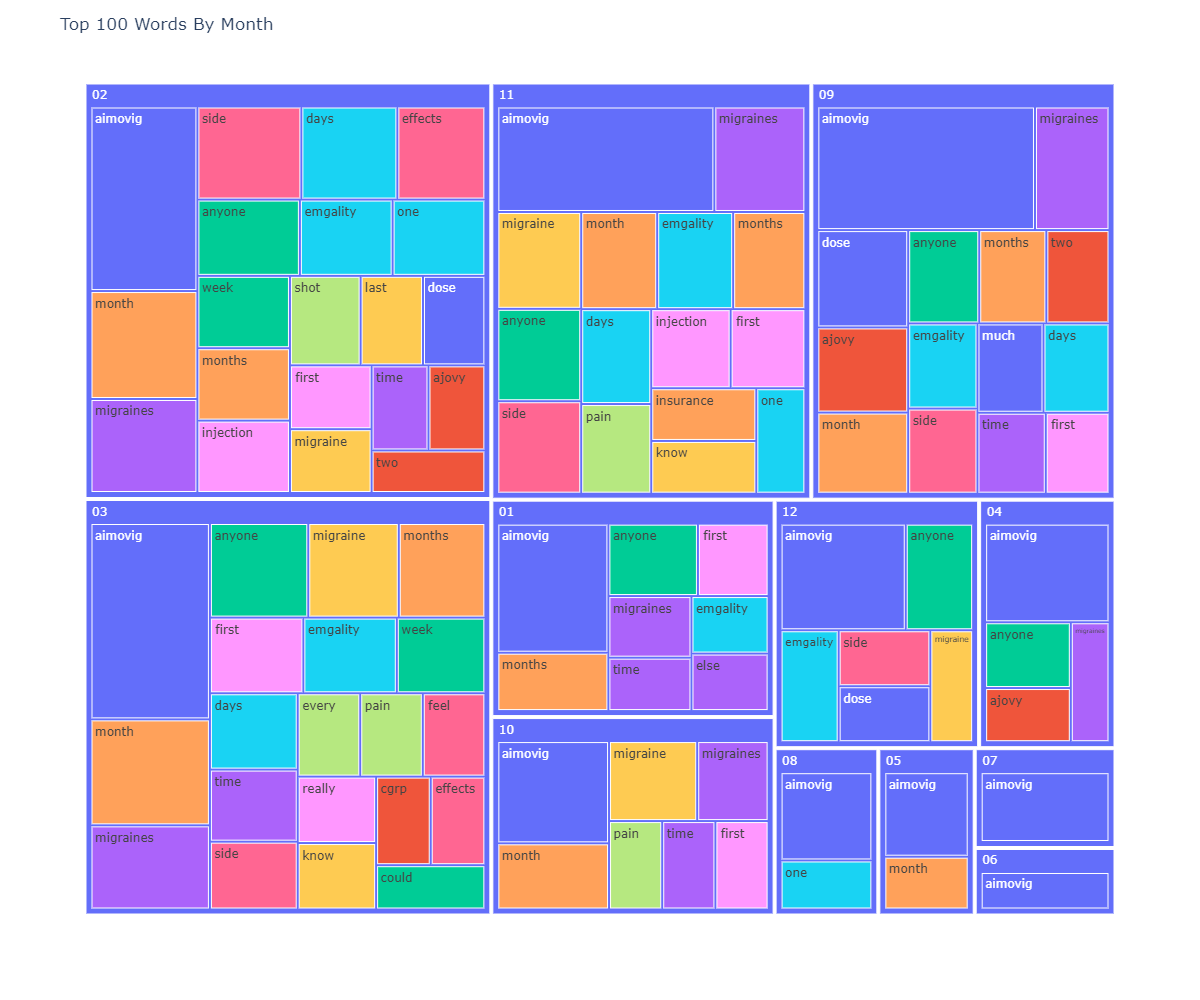

### Visualization 2: Heatmap- Topwords Used Overtime

In [46]:
# aggregate data
subset2 = df.groupby(by=['created_at','word']).count()['ups'].nlargest(100).reset_index().sort_values(by='created_at')
subset2.head(5)

,created_at,word,ups
75,2018-06-29 07:06:00,aimovig,4
76,2018-09-03 04:45:00,migraines,4
77,2018-09-11 01:10:00,dose,4
78,2018-09-11 01:10:00,going,4
80,2018-09-14 19:10:00,prescription,4


In [ ]:
# https://plotly.com/python/heatmaps/

fig = go.Figure(data=go.Heatmap(
        z=subset2['ups'],
        x=subset2['created_at'],
        y=subset2['word'],
        colorscale='Viridis'))

fig.update_layout(
    title='Top Words over Time',
    xaxis_nticks=36,
    width=1000, 
    height=800
  )
fig.show() #uncomment to display interactive version

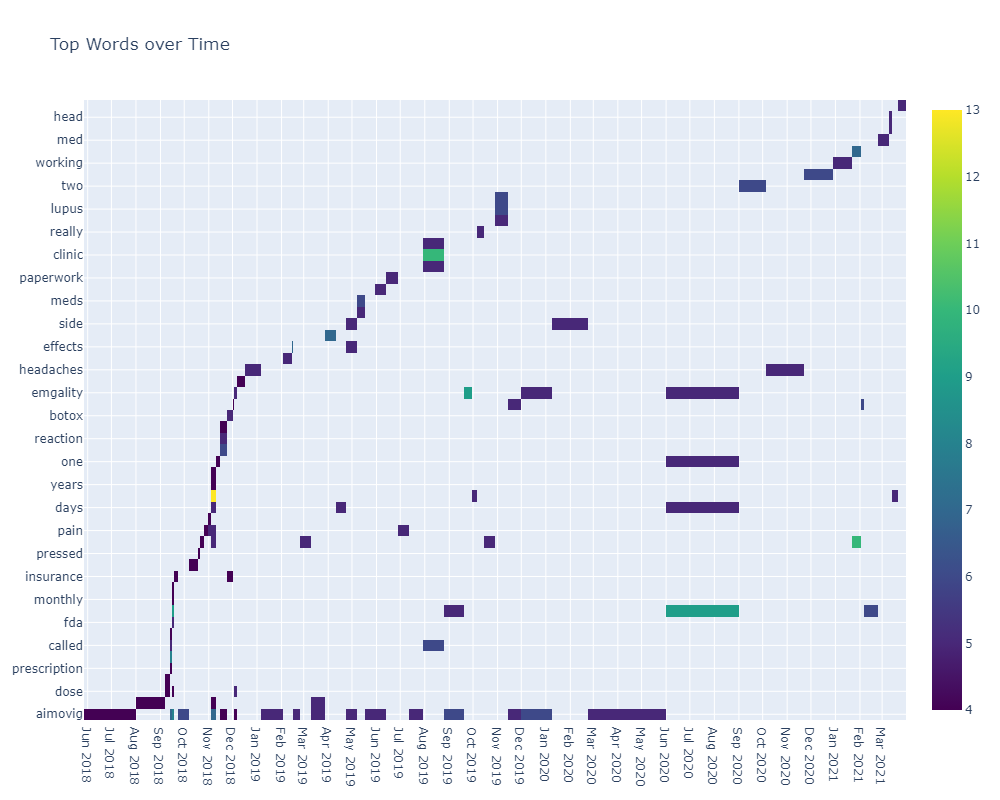

### Visualization 3- Scatterplot of Upvote Ratio Over Time

In [50]:
# aggregate data
subset3 = df[['created_at','upvote_ratio','word','ups']].groupby(by=['created_at','word','upvote_ratio']).count()['ups'].nlargest(100).reset_index().sort_values(by='created_at')
subset3.head(5)

,created_at,word,upvote_ratio,ups
75,2018-06-29 07:06:00,aimovig,1.00,4
76,2018-09-03 04:45:00,migraines,1.00,4
77,2018-09-11 01:10:00,dose,1.00,4
78,2018-09-11 01:10:00,going,1.00,4
80,2018-09-14 19:10:00,prescription,0.86,4


In [ ]:
# https://plotly.com/python/setting-graph-size/
fig = px.scatter(subset3, x="created_at", y="upvote_ratio",color="word")

fig.update_layout(
    title='Upvote Ratio over Time',
    xaxis_nticks=36,
    width=900, 
    height=500
  )
fig.show() #uncomment to display interactive version

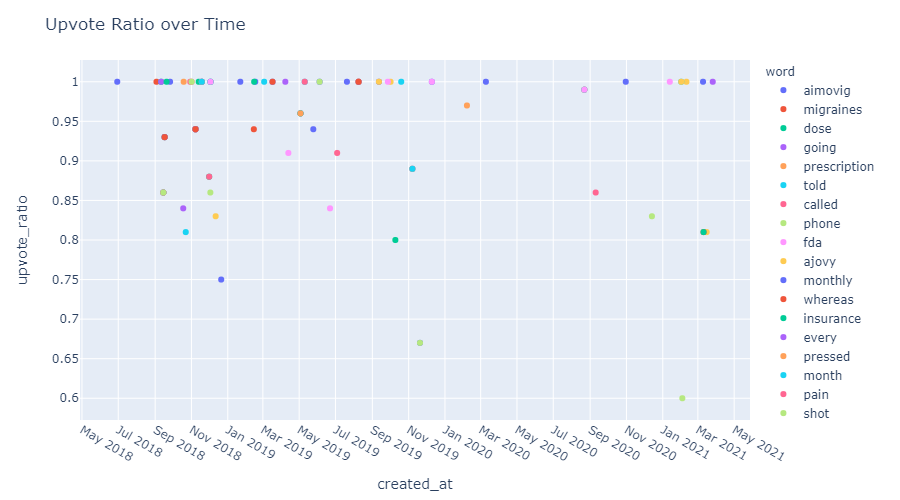

### Part 3:  Brief Analysis of Results

I think that the three visualizations show a similar story over three interpretations. In the treemap, most common words pertain to shots, injections, insurance, and Aimovig. In the heatmap, words likes aimovig, monthly, dose, and emgality appear throughout the timeframe more frequently than other words that are mentioned a few times. Examples include "lupus and paperwork". The posts that receive higher votes include words such as "aimovig, migraines, dose, etc". At a highlevel, this could indicate post including those key words will receive more positive attention from other Reddit users.